# air_passengers RAMP challenge : an overview of the base dataset
<i>Sylvain Tostain (SAIPOL)</i>

## Introduction
The aim of this notebook is to explore the data of this challenge, in order to provide insight for relevant data enrichment.

Let's start by importing some useful modules...

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.set_option('display.max_columns', None)

And in order to have bigger plots (feel free to adjust to your taste)...

In [2]:
# Inspired from https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/

# Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current figure size:", fig_size)
 
# Set figure width to our preferences
fig_size[0] = 12.
fig_size[1] = 9.
plt.rcParams["figure.figsize"] = fig_size
print("Figure size modified to:", fig_size)

Current figure size: [6.0, 4.0]
Figure size modified to: [12.0, 9.0]


## Fetch the data
We fetch the data from the raw dataset of the RAMP kit.

In [3]:
data = pd.read_csv("../data/train.csv.bz2")

At first, we have a look at the timeframe for which we'll need to provide additional data. Let's keep it in mind for future reference.

In [4]:
print("DateOfDeparture ranges from {} up to {}.".format(min(data['DateOfDeparture']),max(data['DateOfDeparture'])))

DateOfDeparture ranges from 2011-09-01 up to 2013-03-05.


## First look at the data
A quick reminder about what is at hand.

In [5]:
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


The departure airports...

In [6]:
print(data['Departure'].sort_values().unique())
print("There are {} different origins.".format(data['Departure'].unique().shape[0]))

['ATL' 'BOS' 'CLT' 'DEN' 'DFW' 'DTW' 'EWR' 'IAH' 'JFK' 'LAS' 'LAX' 'LGA'
 'MCO' 'MIA' 'MSP' 'ORD' 'PHL' 'PHX' 'SEA' 'SFO']
There are 20 different origins.


...and the arrival airports.

In [7]:
print(data['Arrival'].sort_values().unique())
print("There are {} different arrivals.".format(data['Arrival'].unique().shape[0]))

['ATL' 'BOS' 'CLT' 'DEN' 'DFW' 'DTW' 'EWR' 'IAH' 'JFK' 'LAS' 'LAX' 'LGA'
 'MCO' 'MIA' 'MSP' 'ORD' 'PHL' 'PHX' 'SEA' 'SFO']
There are 20 different arrivals.


## Class balances
Let's check whether our classes are balanced or not.

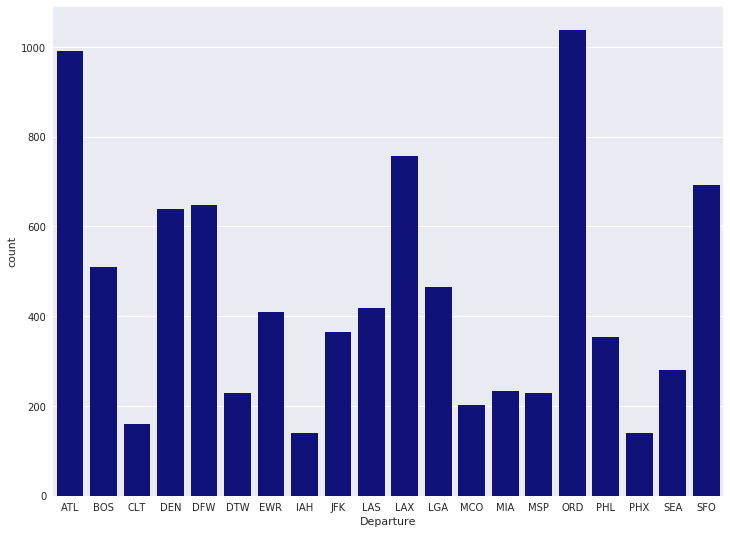

In [8]:
data_sorted = data.sort_values(by='Departure')
sns.countplot(x = 'Departure',
              data = data_sorted,
              color = 'darkblue');

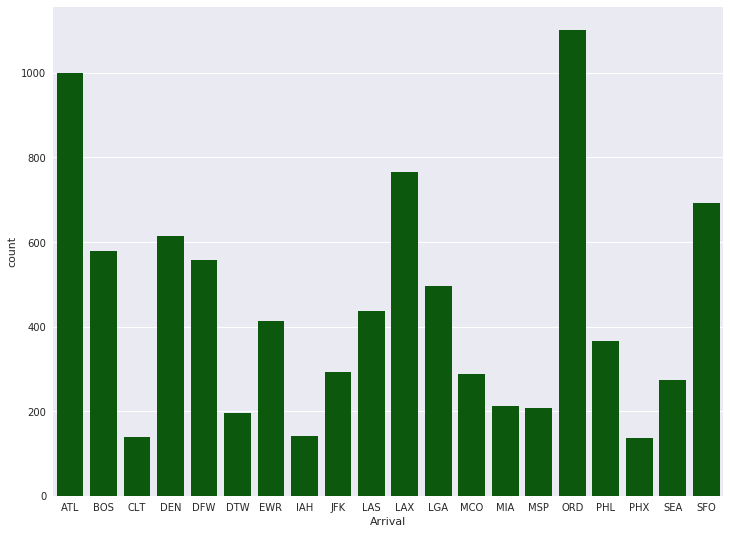

In [9]:
data_sorted = data.sort_values(by='Arrival')
sns.countplot(x = 'Arrival',
              data = data_sorted,
              color = 'darkgreen');

We observe that our classes are somehow imbalanced... And strangely enough, arrivals counts appears different from departure counts for some airports.

We do not check yet if classes are evenly distributed over months or years for the time series, we'll check that later when looking at the time series.

## Are there "bigger" airports?

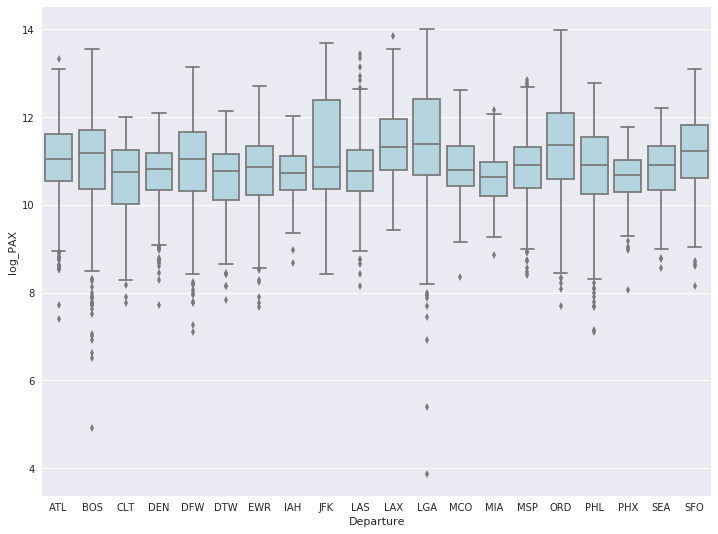

In [10]:
data_sorted = data.sort_values(by='Departure')
sns.boxplot(x = 'Departure',
            y = 'log_PAX',
            data = data_sorted,
            color = 'lightblue');

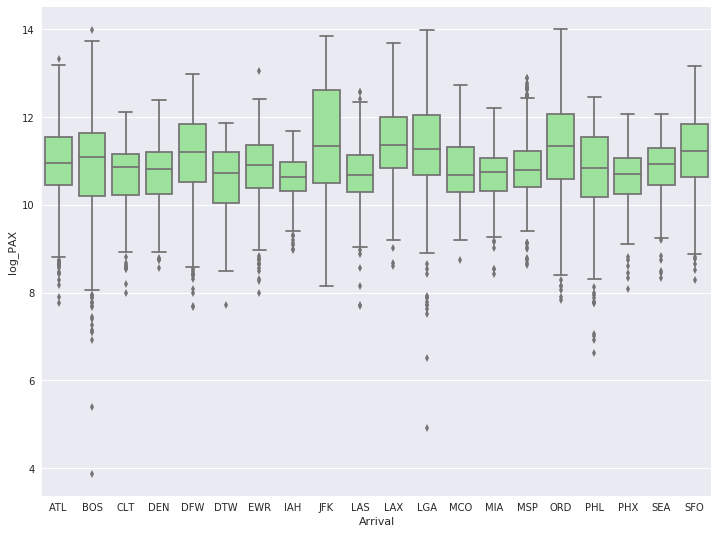

In [11]:
data_sorted = data.sort_values(by='Arrival')
sns.boxplot(x = 'Arrival',
            y = 'log_PAX',
            data = data_sorted,
            color = 'lightgreen');

We observe that `log_PAX` varies between the airports and that values are sometimes relatively different between departures and arrivals.

We also observe that some airports have a greater variability, such as `JFK`, `BOS`, `LGA` and `ORD`.

We eventually observe that a limited number of airports exhibit a heavy tail with a high number of lower values outliers being relatively dispersed, such as `LGA` and `BOS`. Special cause are likely to explain such exceptionnaly low values, such as special events or adverse weather conditions. Should these events be recurrent or predictible, it is our best interest to try and capture them as features into our models.

It is now time to have a look at time series. Before that, a last one for the road...

In [12]:
biggest_airports = data.drop(['DateOfDeparture','std_wtd','WeeksToDeparture'], axis=1)
biggest_airports = biggest_airports.groupby(['Departure']).sum()
biggest_airports = biggest_airports.sort_values(by = ['log_PAX'],ascending = False)
print("Our big 5...")
print(biggest_airports.head(5))
biggest_airports = list(biggest_airports.head(5).index)

Our big 5...
                log_PAX
Departure              
ORD        11700.745401
ATL        10888.095073
LAX         8650.661181
SFO         7780.073748
DFW         7081.540131


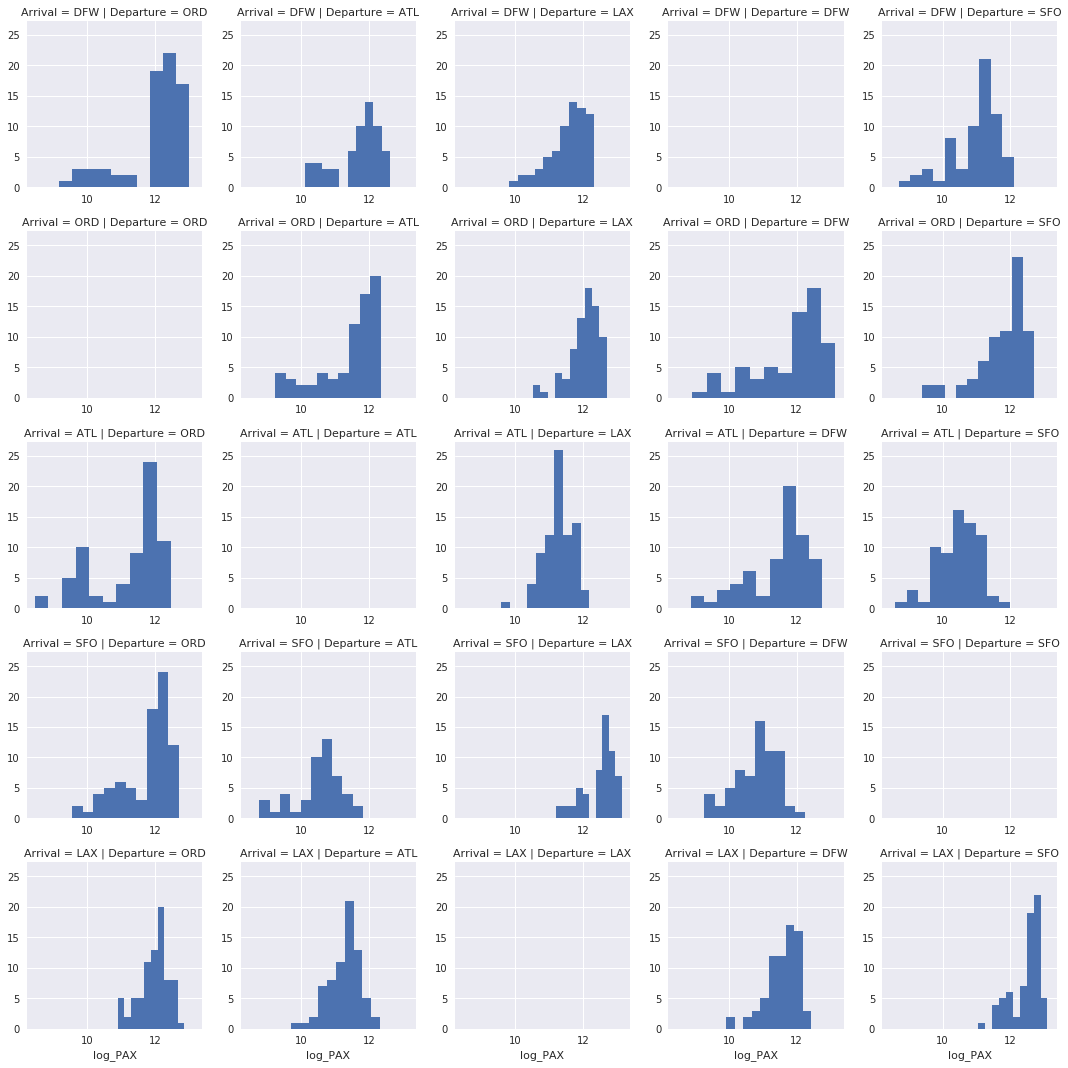

In [13]:
lines_to_drop = [index for index in data.index if (
    ( data.iloc[index]['Departure'] not in biggest_airports) or
    ( data.iloc[index]['Arrival'] not in biggest_airports))]

data_biggest = data.drop(lines_to_drop)
data_biggest = data_biggest.drop(['DateOfDeparture'], axis=1)

g = sns.FacetGrid(data_biggest, col = 'Departure', row = 'Arrival')
g = g.map(plt.hist,'log_PAX')

## Looking for seasonality
We derive some labels to address seasonality (directly inspired from the RAMP starting kit). Nevertheless, we do not create variables for the day of the month, as we would probably not be able to derive relevant seasonality from this variable.
### Preparation of the data

In [14]:
# Taken from the RAMP starting kit.

data_encoded = data

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
# data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))

In [15]:
data_encoded.head(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,2012,6,19,1,25,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,2012,9,10,0,37,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,2012,10,5,4,40,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,2011,10,9,6,40,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,2012,2,21,1,8,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Yearly effect
There might be a slightly lower log_PAX in 2013, but it is unclear.

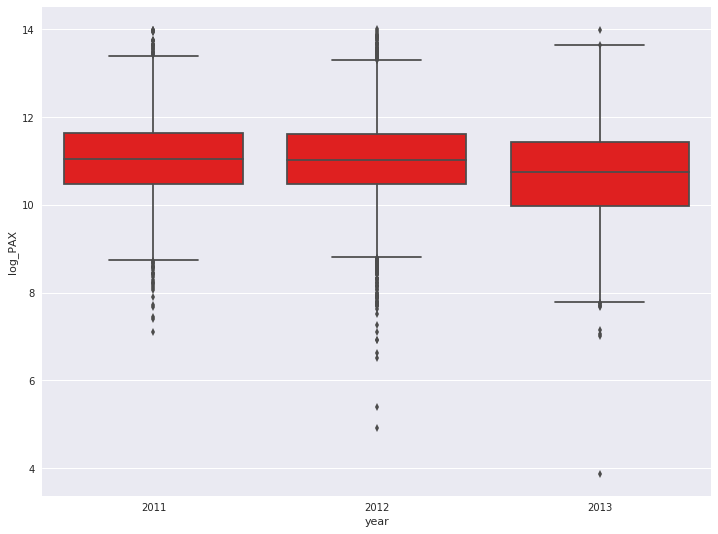

In [16]:
data_encoded_sorted = data_encoded.sort_values(by='year')
sns.boxplot(x = 'year',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Red');

### Monthly seasonality
It appears that there might be a slight monthly seasonality.

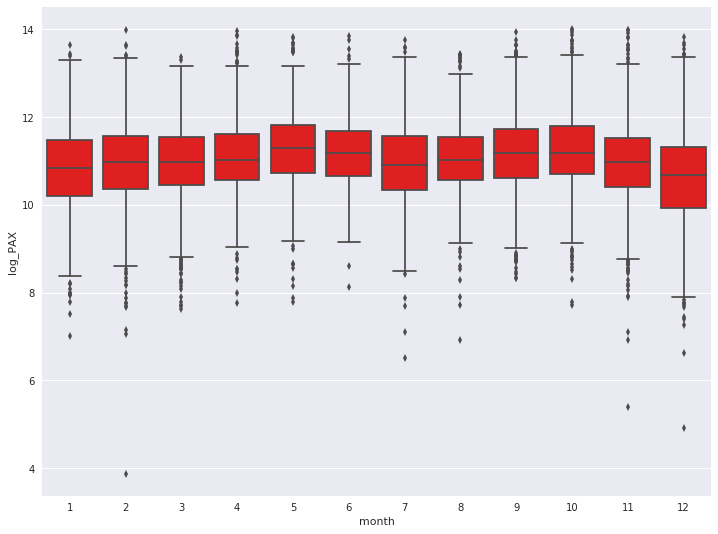

In [17]:
data_encoded_sorted = data_encoded.sort_values(by='month')
sns.boxplot(x = 'month',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Red');

Let's simplify this representation...

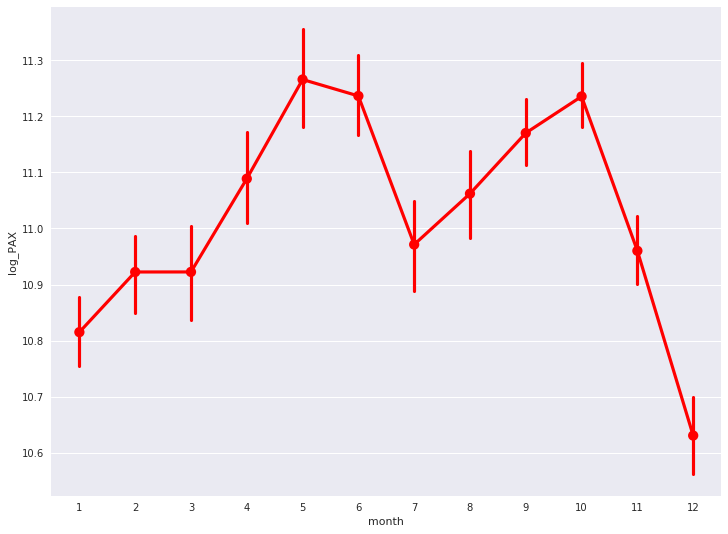

In [18]:
sns.pointplot(x = 'month',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Red');

Its is obvious that there is monthly seasonality, that depends on the airport... This may be linked to local events justifying deartures (like university breaks...). Note that some months/airports are subject to higher variabilities.

TODO : Get university vacation times and towns having universities... sea Phenix/April.

TODO : Get latitudes and longitudes, since it may impact Departures/Arrivals at certain times of the year (summer, winter,...)

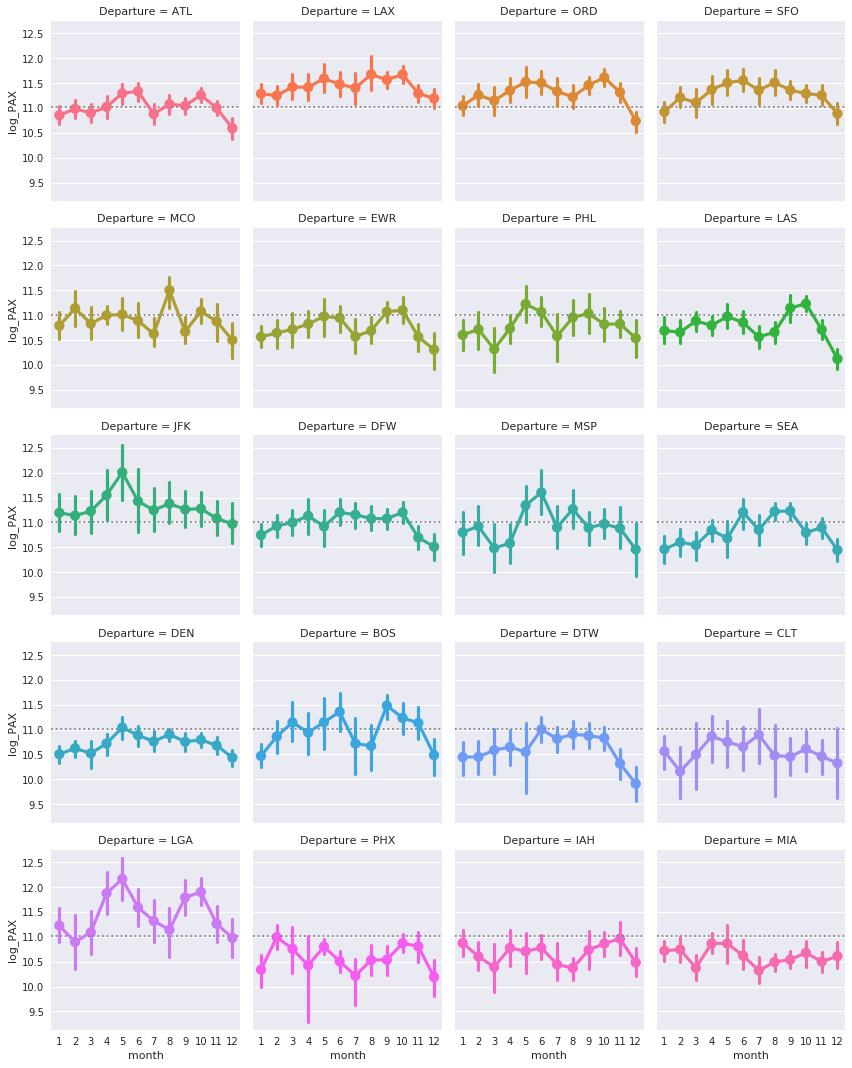

In [19]:
### Inspired from seaborn documentation :
# https://seaborn.pydata.org

# Initialize a grid of plots with an Axes for each Departure point
grid = sns.FacetGrid(data_encoded_sorted, col="Departure", hue ="Departure" , col_wrap=4)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=data_encoded_sorted.log_PAX.median(), ls=":", c=".5")

# Draw a pointplot to show the trajectory of each seasonality
grid.map(sns.pointplot, "month", "log_PAX");

Let's have a look at arrivals...

Same comments, some cities are clearly not associated with vacations (see Boston), where some show crowdy months (EWR in in June is Newark, New Jersey)

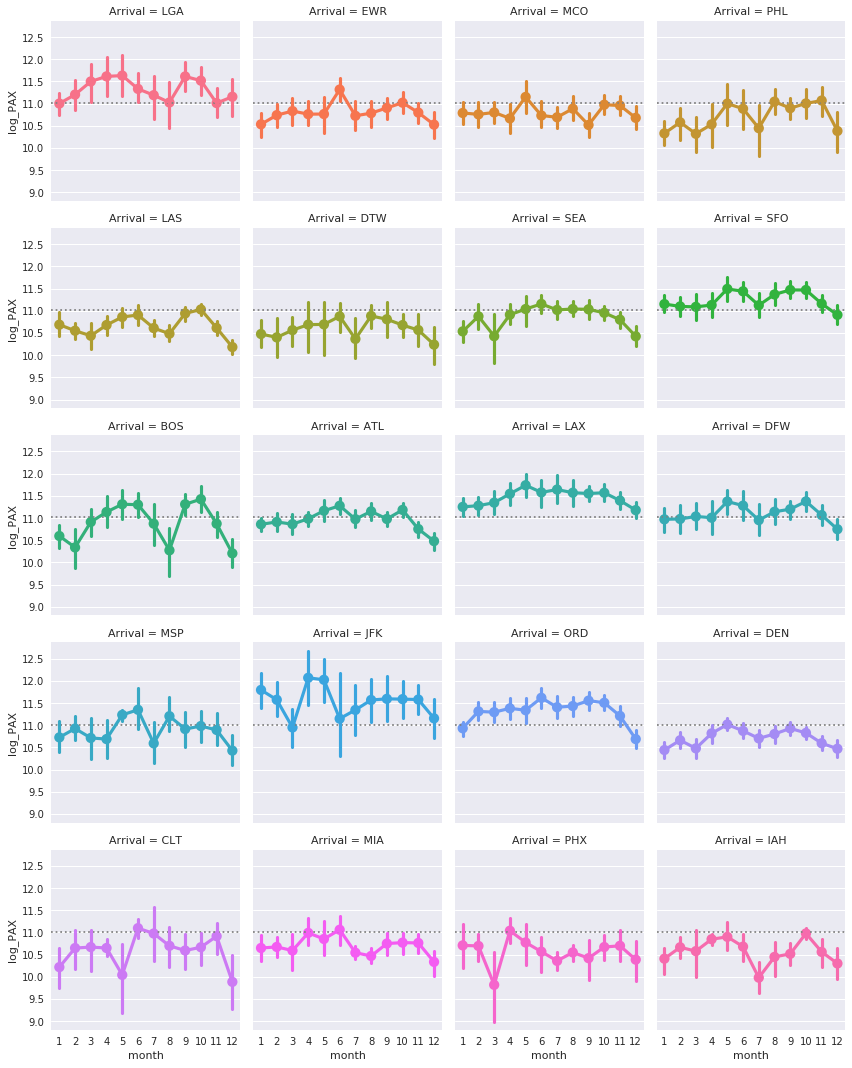

In [20]:
### Inspired from seaborn documentation :
# https://seaborn.pydata.org

# Initialize a grid of plots with an Axes for each Departure point
grid = sns.FacetGrid(data_encoded_sorted, col="Arrival", hue ="Arrival" , col_wrap=4)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=data_encoded_sorted.log_PAX.median(), ls=":", c=".5")

# Draw a pointplot to show the trajectory of each seasonality
grid.map(sns.pointplot, "month", "log_PAX");

Let's see if there is a weekly seasonality as well...

### Weekly seasonality

Let's try the same.

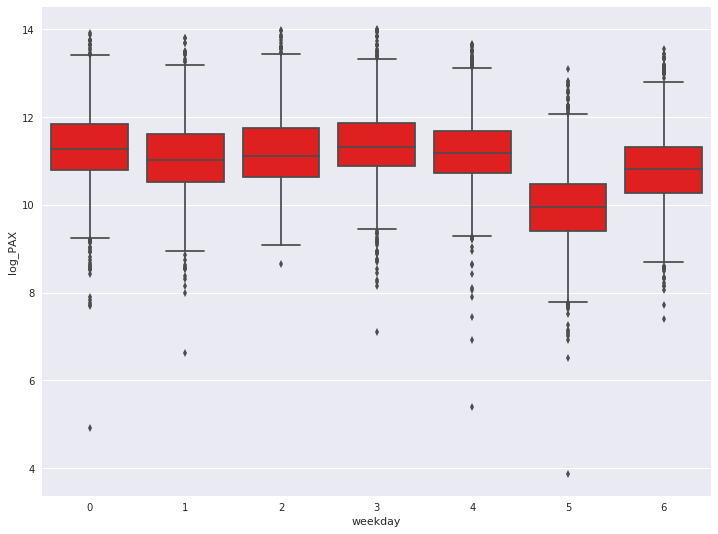

In [21]:
data_encoded_sorted = data_encoded.sort_values(by='month')
sns.boxplot(x = 'weekday',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Red');

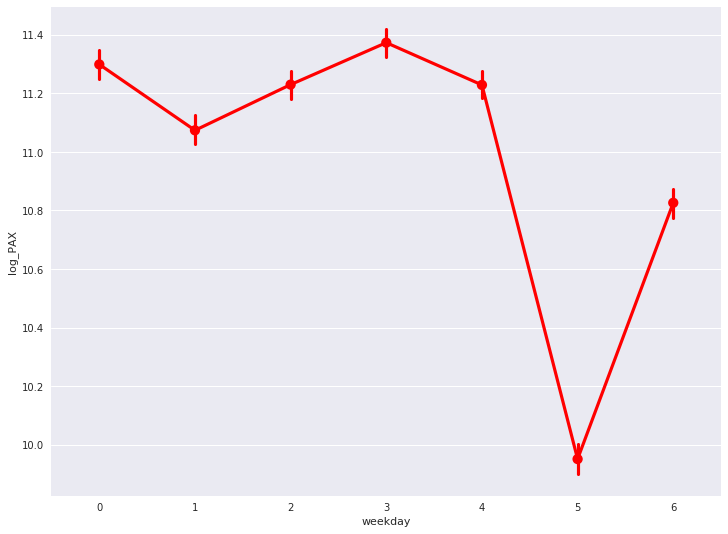

In [22]:
sns.pointplot(x = 'weekday',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Red');

Nothing really noteworthy between Airports/Weekdays... apart perhaps the fact that some airports strangely show little drop in arrivals on day 6 (which day is it ?)

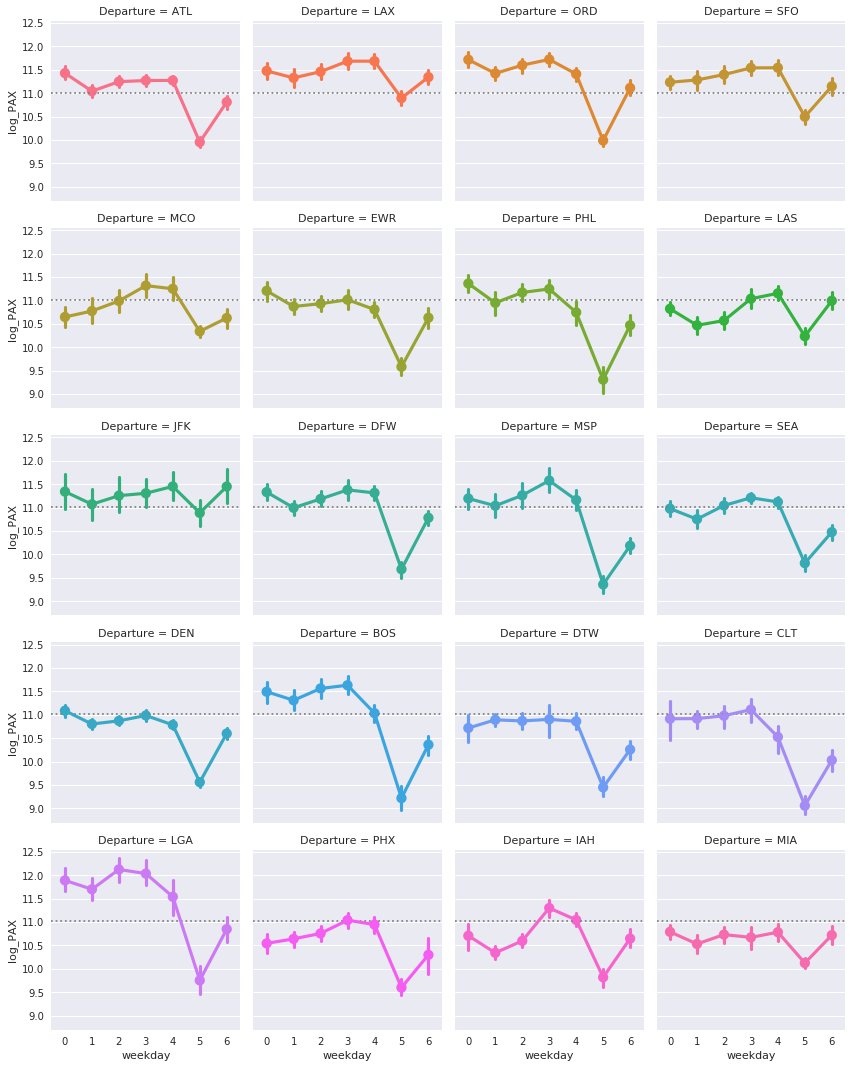

In [23]:
# Initialize a grid of plots with an Axes for each Departure point
grid = sns.FacetGrid(data_encoded_sorted, col="Departure", hue ="Departure" , col_wrap=4)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=data_encoded_sorted.log_PAX.median(), ls=":", c=".5")

# Draw a pointplot to show the trajectory of each seasonality
grid.map(sns.pointplot, "weekday", "log_PAX");

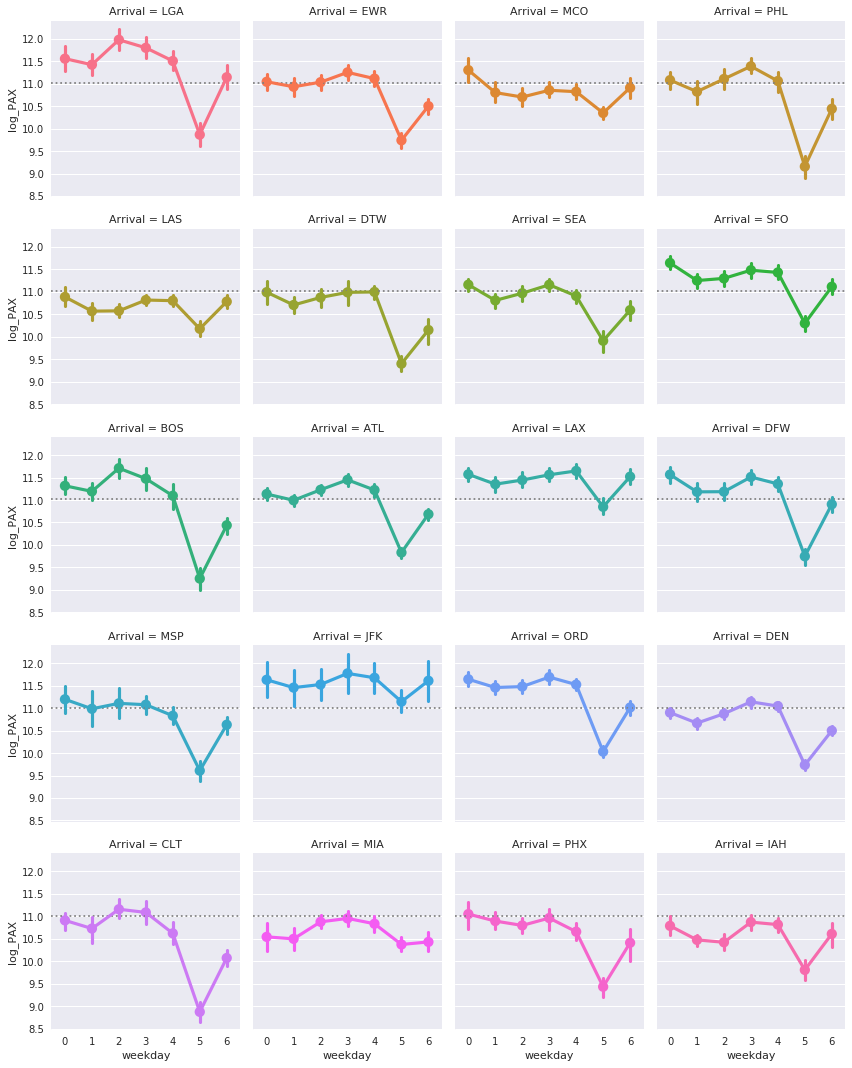

In [24]:
# Initialize a grid of plots with an Axes for each Departure point
grid = sns.FacetGrid(data_encoded_sorted, col="Arrival", hue ="Arrival" , col_wrap=4)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=data_encoded_sorted.log_PAX.median(), ls=":", c=".5")

# Draw a pointplot to show the trajectory of each seasonality
grid.map(sns.pointplot, "weekday", "log_PAX");

### Remarkable weeks in the year
Let's now look at remarkable weeks...

Some weeks show significantly lower log_PAX, like weeks 1, 10, 14, 27, 36, 47, 51 and 52.

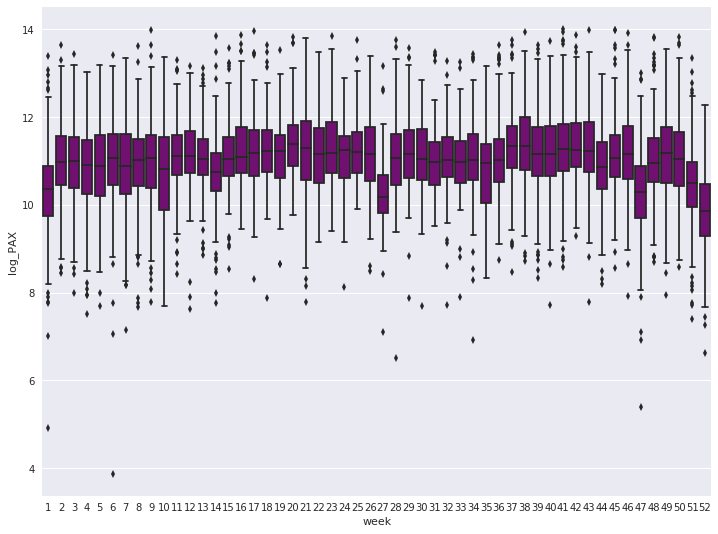

In [25]:
sns.boxplot(x = 'week',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Purple');

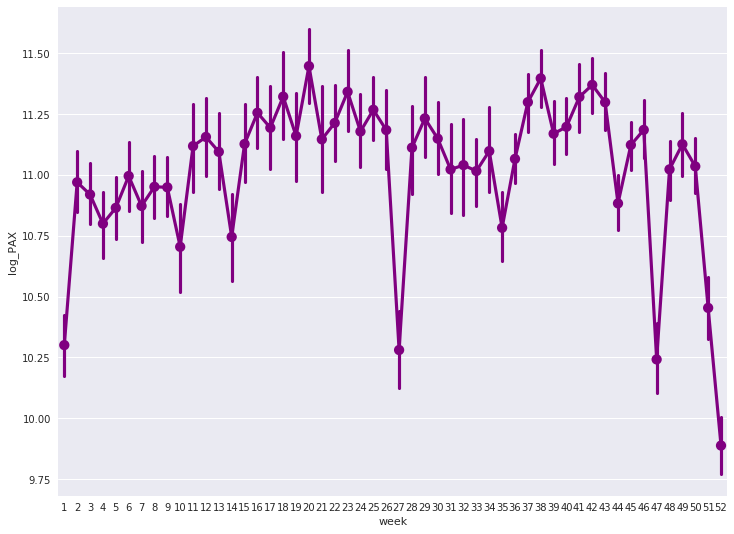

In [26]:
sns.pointplot(x = 'week',
            y = 'log_PAX',
            data = data_encoded_sorted,
            color = 'Purple');

Let's see if this is also dependent to the airport...

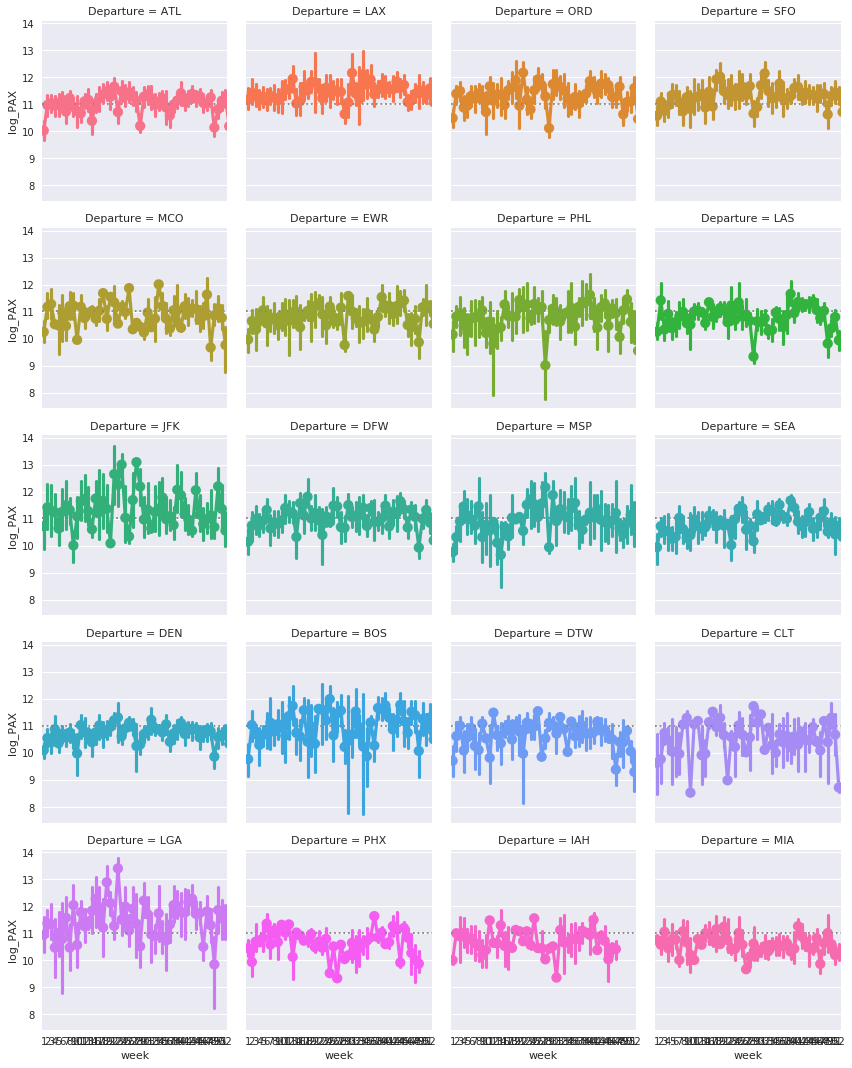

In [27]:
# Initialize a grid of plots with an Axes for each Departure point
grid = sns.FacetGrid(data_encoded_sorted, col="Departure", hue ="Departure" , col_wrap=4)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=data_encoded_sorted.log_PAX.median(), ls=":", c=".5")

# Draw a pointplot to show the trajectory of each seasonality
grid.map(sns.pointplot, "week", "log_PAX");